In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! tar -xf drive/MyDrive/dataset.tar.gz
! mkdir dataset/test/unknown
! mv dataset/test/*.png dataset/test/unknown

This shell sript substitutes all the space characters to '_' character, this helps creating the dataset for validation. If we don't do this when the script will loop over the train folder it returns the name of the folder and also all the words of the folder names. For example "Barred Spiral" it returns "Barred Spiral","Barred" and "Spiral"

In [ ]:
%%shell
cd dataset/train
find -name "* *" -print0 | sort -rz | \
  while read -d $'\0' f; do mv -v "$f" "$(dirname "$f")/$(basename "${f// /_}")"; done

renamed './Unbarred Tight Spiral' -> './Unbarred_Tight_Spiral'
renamed './Unbarred Loose Spiral' -> './Unbarred_Loose_Spiral'
renamed './Round Smooth' -> './Round_Smooth'
renamed './In-between Round Smooth' -> './In-between_Round_Smooth'
renamed './Edge-on without Bulge' -> './Edge-on_without_Bulge'
renamed './Edge-on with Bulge' -> './Edge-on_with_Bulge'
renamed './Cigar Shaped Smooth' -> './Cigar_Shaped_Smooth'
renamed './Barred Spiral' -> './Barred_Spiral'


The validation dataset is created by taking 20% of the images of the train dataset.

In [ ]:
%%shell
cd dataset/train
mkdir ../validation
for dir in */ ; do
  # Getting the number of images in the galaxy class folder
  n_img=$(($(find $dir -type f | wc -l)))
  # Number of images that we need to move to the validation folder
  n_validation=$((($n_img / 10) * 2))
  
  echo "$dir: $n_img -> $n_validation"
  mkdir "../validation/$dir"
  cd $dir

  # Moving the images
  i=0
  for file in * ; do
    if (( i >= $n_validation )); then
      break
    fi
    i=$((i+1))
    mv "$file" "../../validation/$dir$file"
  done
  cd ..
done

Barred_Spiral/: 1430 -> 286
Cigar_Shaped_Smooth/: 234 -> 46
Disturbed/: 757 -> 150
Edge-on_with_Bulge/: 1311 -> 262
Edge-on_without_Bulge/: 996 -> 198
In-between_Round_Smooth/: 1419 -> 282
Merging/: 1297 -> 258
Round_Smooth/: 1851 -> 370
Unbarred_Loose_Spiral/: 1840 -> 368
Unbarred_Tight_Spiral/: 1280 -> 256


Revert back the folder names

In [ ]:
%%shell
cd dataset/train
find -name "*_*" -print0 | sort -rz | \
  while read -d $'\0' f; do mv -v "$f" "$(dirname "$f")/$(basename "${f//_/ }")"; done

renamed './Unbarred_Tight_Spiral' -> './Unbarred Tight Spiral'
renamed './Unbarred_Loose_Spiral' -> './Unbarred Loose Spiral'
renamed './Round_Smooth' -> './Round Smooth'
renamed './In-between_Round_Smooth' -> './In-between Round Smooth'
renamed './Edge-on_without_Bulge' -> './Edge-on without Bulge'
renamed './Edge-on_with_Bulge' -> './Edge-on with Bulge'
renamed './Cigar_Shaped_Smooth' -> './Cigar Shaped Smooth'
renamed './Barred_Spiral' -> './Barred Spiral'


Also correct the folder names from the validation

In [ ]:
%%shell
cd dataset/validation
find -name "*_*" -print0 | sort -rz | \
  while read -d $'\0' f; do mv -v "$f" "$(dirname "$f")/$(basename "${f//_/ }")"; done

renamed './Unbarred_Tight_Spiral' -> './Unbarred Tight Spiral'
renamed './Unbarred_Loose_Spiral' -> './Unbarred Loose Spiral'
renamed './Round_Smooth' -> './Round Smooth'
renamed './In-between_Round_Smooth' -> './In-between Round Smooth'
renamed './Edge-on_without_Bulge' -> './Edge-on without Bulge'
renamed './Edge-on_with_Bulge' -> './Edge-on with Bulge'
renamed './Cigar_Shaped_Smooth' -> './Cigar Shaped Smooth'
renamed './Barred_Spiral' -> './Barred Spiral'


In [ ]:
BATCH_SIZE = 64

In [ ]:
import torch, torchvision
from torch import nn
from torchvision import transforms
transform = torchvision.transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class GalaxyImageFolder(torchvision.datasets.ImageFolder):
  def __getitem__(self, index):
    return super().__getitem__(index), self.imgs[index][0]


cuda = torch.device("cuda:0")

train_dataset = torchvision.datasets.ImageFolder('./dataset/train/', transform=transform)
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True, pin_memory=True)

validation_dataset = torchvision.datasets.ImageFolder('./dataset/validation', transform=transform)
validation_loader = torch.utils.data.dataloader.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=1)

test_dataset = GalaxyImageFolder('./dataset/test', transform=transform)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)

labels_name = ["Barred Spiral","Cigar Shaped Smooth","Disturbed","Edge-on with Bulge","Edge-on without Bulge",
               "In-between Round Smooth","Merging","Round Smooth","Unbarred Loose Spiral","Unbarred Tight Spiral"]



In [ ]:
class ClassificationMetrics:

  # Constructor takes the number of classes
  def __init__(self, num_classes=10):
    self.num_classes = num_classes
    # Initialize a confusion matrix
    self.C = torch.zeros(num_classes, num_classes, device=cuda) 

  # Update the confusion matrix with the new scores
  def add(self, yp, yt):
    # yp: 1D tensor with predictions
    # yt: 1D tensor with ground-truth targets
    with torch.no_grad(): # We require no computation graph
      self.C+=(yt*self.C.shape[1]+yp).bincount(minlength=self.C.numel()).view(self.C.shape).float()

  def clear(self):
    # We set the confusion matrix to zero
    self.C.zero_()

  # Computes the global accuracy
  def acc(self):
    return self.C.diag().sum().item()/self.C.sum()

  # Computes the class-averaged accuracy
  def mAcc(self):
    return (self.C.diag()/self.C.sum(-1)).mean().item()

  # Computers the class-averaged Intersection over Union
  def mIoU(self):
    return (self.C.diag()/(self.C.sum(0)+self.C.sum(1)-self.C.diag())).mean().item()

  # Returns the confusion matrix
  def confusion_matrix(self):
    return self.C


In [ ]:
import pickle

# This class store the accuracies for every epochs
class ModelPlot:
  def __init__(self, name):
    self.name = name
    self.mAcc = []
    self.acc = []
    self.mIoU = []

  def add_mAcc(self, mAcc):
    self.mAcc.append(mAcc)

  def mAcc(self):
    return self.mAcc

  def add_acc(self, acc):
    self.acc.append(acc)

  def acc(self):
    return self.acc
  
  def add_mIoU(self, mIoU):
    self.mIoU.append(mIoU)

  def mIoU(self):
    return self.mIoU

  def save(self):
    with open(self.name, 'wb') as file:
      pickle.dump(self, file)

In [ ]:
import torch.utils.tensorboard as tb
%load_ext tensorboard
tboard = tb.SummaryWriter("exps/{}".format("Resnet50-1"))

In [ ]:
def create_fixed_features_model(trained=True, learning_rate=0.01):
  model = torchvision.models.resnet50(pretrained=trained)
  #Freezing the parameters
  for param in model.parameters():
    param.requres_grad = False
  
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, 10)
  model.to(cuda)
  optimizer = torch.optim.SGD(model.fc.parameters(), lr=learning_rate)
  
  return model, optimizer

def create_fine_tuning_model(trained=True, learning_rate=0.01):
  model = torchvision.models.resnet50(pretrained=trained)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, 10)
  model.to(cuda)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  return model, optimizer


In [ ]:
class ImagePrediction:
  def __init__(self, id, class_name):
    self.img_id = int(id)
    self.class_name = class_name

In [ ]:
# pickle is used to copy the model
import pickle


def validate(model, best_model, validation_loader, metric_tracker, epoch, plot):
  model.eval()
  metric_tracker.clear()


  with torch.no_grad(): 
    for img, label in validation_loader:
      img = img.to(cuda)
      img = img.type(torch.cuda.FloatTensor)
      label = label.to(cuda)

      Y = model(img)
      y = Y.argmax(-1)

      metric_tracker.add(y, label)

      tboard.add_scalar('val/acc', metric_tracker.acc(), epoch)
      tboard.add_scalar('val/mAcc', metric_tracker.mAcc(), epoch)
      tboard.add_scalar('val/mIoU', metric_tracker.mIoU(), epoch)

    if metric_tracker.acc() > best_model[1]:
      best_model = (pickle.loads(pickle.dumps(model)), metric_tracker.acc())

  print("\tVALID | acc: {:.4f} | mAcc: {:.4f} | mIoU: {:.4f}".format(
    metric_tracker.acc(), metric_tracker.mAcc(), metric_tracker.mIoU()
  ))
  plot.add_acc(metric_tracker.acc())
  plot.add_mAcc(metric_tracker.mAcc())
  plot.add_mIoU(metric_tracker.mIoU())

  return best_model

def train_and_validate(model, train_loader, valid_loader, optimizer, criterion, step_scheduler, n_epochs, plot):

  metric_tracker = ClassificationMetrics(10)
  # First value is the model, the second is the accuracy
  best_model = ([], 0.0)

  model.train()

  for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    metric_tracker.clear()

    for i, (images, label) in enumerate(train_loader):
      images = images.to(cuda)
      images = images.type(torch.cuda.FloatTensor)
      label = label.to(cuda)

      Y = model(images)

      loss = criterion(Y, label)
      optimizer.zero_grad()

      tboard.add_scalar('train/loss', loss.item(), epoch*len(train_loader)+i)

      loss.backward()
      optimizer.step()
      
      y = Y.argmax(-1)
      metric_tracker.add(y, label)
      
      tboard.add_scalar('train/acc', metric_tracker.acc(), epoch)
      tboard.add_scalar('train/mAcc', metric_tracker.mAcc(), epoch)
      tboard.add_scalar('train/mIoU', metric_tracker.mIoU(), epoch)
      tboard.add_scalar('train/lr', step_scheduler.get_last_lr()[0], epoch)
    
    step_scheduler.step()

    print("\tTRAIN | acc: {:.4f} | mAcc: {:.4f} | mIoU: {:.4f}".format(
      metric_tracker.acc(), metric_tracker.mAcc(), metric_tracker.mIoU()
    ))

    best_model = validate(model, best_model, valid_loader, metric_tracker, epoch, plot)

  return best_model

In [ ]:
def test(model):
  model.eval()
  results = []

  with torch.no_grad(): 
    for i, ((img, label), filename) in enumerate(test_loader):
      img = img.to(cuda)
      img = img.type(torch.cuda.FloatTensor)
      label = label.to(cuda)

      Y = model(img)
      y = Y.argmax(-1)
     
      for j, pred in enumerate(y):
        item_index = (BATCH_SIZE*i + j)
        prediction = ImagePrediction(test_dataset.__getitem__(item_index)[1][23:-4], labels_name[pred])
        results.append(prediction)

  return results

In [ ]:
#model_save_name = 'classifier.pt'
#path = F"/content/drive/My Drive/{model_save_name}"
#model = torchvision.models.resnet50(pretrained=trained)
#model.load_state_dict(torch.load(path))

#mdl_pred = test(model)

In [ ]:
import csv

# Store the accuracies in gdrive
def store_data(mdl_plotter):

  with open(f'/content/drive/My Drive/{mdl_plotter.name}.csv', 'w') as f:
      writer = csv.writer(f)
      writer.writerow(["Acc", "mAcc", "IoU"])
      for i in range(len(mdl_plotter.acc)):
        #print(mdl_plotter.acc[i].item(), mdl_plotter.mAcc[i].item(), mdl_plotter.mIoU[i].item())
        writer.writerow([mdl_plotter.acc[i].item(), mdl_plotter.mAcc[i], mdl_plotter.mIoU[i]])

In [ ]:
fine_tuning_mdl, optimizer = create_fine_tuning_model()
criterion = nn.CrossEntropyLoss().to(cuda)
stepper_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
fine_tuning_plt = ModelPlot('Fine Tuning')
fine_tuning_mdl = train_and_validate(fine_tuning_mdl, train_loader, validation_loader, optimizer, criterion, stepper_lr, 25, fine_tuning_plt)
fine_tuning_pred = test(fine_tuning_mdl[0])

Epoch 1
	TRAIN | acc: 0.5814 | mAcc: 0.5061 | mIoU: 0.3613
	VALID | acc: 0.7052 | mAcc: 0.6173 | mIoU: 0.4962
Epoch 2
	TRAIN | acc: 0.5630 | mAcc: 0.5181 | mIoU: 0.3685
	VALID | acc: 0.7048 | mAcc: 0.6852 | mIoU: 0.5341
Epoch 3
	TRAIN | acc: 0.7382 | mAcc: 0.7056 | mIoU: 0.5660
	VALID | acc: 0.7629 | mAcc: 0.7324 | mIoU: 0.5983
Epoch 4
	TRAIN | acc: 0.7939 | mAcc: 0.7690 | mIoU: 0.6421
	VALID | acc: 0.8025 | mAcc: 0.7642 | mIoU: 0.6513
Epoch 5
	TRAIN | acc: 0.8407 | mAcc: 0.8210 | mIoU: 0.7123
	VALID | acc: 0.7977 | mAcc: 0.7856 | mIoU: 0.6622
Epoch 6
	TRAIN | acc: 0.9103 | mAcc: 0.8986 | mIoU: 0.8261
	VALID | acc: 0.8227 | mAcc: 0.8047 | mIoU: 0.6832
Epoch 7
	TRAIN | acc: 0.9242 | mAcc: 0.9129 | mIoU: 0.8493
	VALID | acc: 0.8255 | mAcc: 0.8071 | mIoU: 0.6906
Epoch 8
	TRAIN | acc: 0.9311 | mAcc: 0.9214 | mIoU: 0.8625
	VALID | acc: 0.8243 | mAcc: 0.8087 | mIoU: 0.6890
Epoch 9
	TRAIN | acc: 0.9407 | mAcc: 0.9323 | mIoU: 0.8798
	VALID | acc: 0.8243 | mAcc: 0.8006 | mIoU: 0.6851
Epoch 10
	

In [ ]:
store_data(fine_tuning_plt)

In [ ]:
fixed_feat_mdl, optimizer = create_fixed_features_model(learning_rate=0.01)
criterion = nn.CrossEntropyLoss().to(cuda)
stepper_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.8)
fixed_feat_plt = ModelPlot('Fixed Feature Extractor')
fixed_feat_mdl = train_and_validate(fixed_feat_mdl, train_loader, validation_loader, optimizer, criterion, stepper_lr, 25, fixed_feat_plt)
fixed_feat_pred = test(fixed_feat_mdl[0])

Epoch 1
	TRAIN | acc: 0.3474 | mAcc: 0.2860 | mIoU: 0.1713
	VALID | acc: 0.4519 | mAcc: 0.3874 | mIoU: 0.2423
Epoch 2
	TRAIN | acc: 0.4709 | mAcc: 0.4049 | mIoU: 0.2665
	VALID | acc: 0.4875 | mAcc: 0.4203 | mIoU: 0.2767
Epoch 3
	TRAIN | acc: 0.4960 | mAcc: 0.4300 | mIoU: 0.2875
	VALID | acc: 0.4838 | mAcc: 0.4126 | mIoU: 0.2734
Epoch 4
	TRAIN | acc: 0.5136 | mAcc: 0.4473 | mIoU: 0.3035
	VALID | acc: 0.4972 | mAcc: 0.4379 | mIoU: 0.2979
Epoch 5
	TRAIN | acc: 0.5188 | mAcc: 0.4535 | mIoU: 0.3099
	VALID | acc: 0.4992 | mAcc: 0.4298 | mIoU: 0.2872
Epoch 6
	TRAIN | acc: 0.5247 | mAcc: 0.4596 | mIoU: 0.3158
	VALID | acc: 0.5028 | mAcc: 0.4447 | mIoU: 0.3003
Epoch 7
	TRAIN | acc: 0.5298 | mAcc: 0.4671 | mIoU: 0.3229
	VALID | acc: 0.5077 | mAcc: 0.4454 | mIoU: 0.3046
Epoch 8
	TRAIN | acc: 0.5343 | mAcc: 0.4719 | mIoU: 0.3267
	VALID | acc: 0.5040 | mAcc: 0.4503 | mIoU: 0.3074
Epoch 9
	TRAIN | acc: 0.5431 | mAcc: 0.4827 | mIoU: 0.3382
	VALID | acc: 0.5153 | mAcc: 0.4628 | mIoU: 0.3168
Epoch 10
	

KeyboardInterrupt: ignored

In [ ]:
store_data(fixed_feat_plt)

In [ ]:
train_resnet_mdl, optimizer = create_fine_tuning_model(trained=False, learning_rate=0.1)
criterion = nn.CrossEntropyLoss().to(cuda)
stepper_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
resnet_plt = ModelPlot('Trained Resnet')
train_resnet_mdl = train_and_validate(train_resnet_mdl, train_loader, validation_loader, optimizer, criterion, stepper_lr, 25, resnet_plt)
resnet_pred = test(train_resnet_mdl[0])

Epoch 1
	TRAIN | acc: 0.1742 | mAcc: 0.1290 | mIoU: 0.0560
	VALID | acc: 0.2108 | mAcc: 0.1458 | mIoU: 0.0447
Epoch 2
	TRAIN | acc: 0.2293 | mAcc: 0.1680 | mIoU: 0.0758
	VALID | acc: 0.2387 | mAcc: 0.1668 | mIoU: 0.0584
Epoch 3
	TRAIN | acc: 0.2804 | mAcc: 0.2263 | mIoU: 0.1230
	VALID | acc: 0.3045 | mAcc: 0.2455 | mIoU: 0.1327
Epoch 4
	TRAIN | acc: 0.3239 | mAcc: 0.2738 | mIoU: 0.1557
	VALID | acc: 0.3679 | mAcc: 0.3329 | mIoU: 0.1794
Epoch 5
	TRAIN | acc: 0.3777 | mAcc: 0.3254 | mIoU: 0.1964
	VALID | acc: 0.4269 | mAcc: 0.3775 | mIoU: 0.2392
Epoch 6
	TRAIN | acc: 0.4623 | mAcc: 0.4029 | mIoU: 0.2609
	VALID | acc: 0.4709 | mAcc: 0.4128 | mIoU: 0.2666
Epoch 7
	TRAIN | acc: 0.4811 | mAcc: 0.4204 | mIoU: 0.2773
	VALID | acc: 0.4733 | mAcc: 0.4208 | mIoU: 0.2634
Epoch 8
	TRAIN | acc: 0.5053 | mAcc: 0.4404 | mIoU: 0.2952
	VALID | acc: 0.5113 | mAcc: 0.4451 | mIoU: 0.3007
Epoch 9
	TRAIN | acc: 0.5283 | mAcc: 0.4620 | mIoU: 0.3161
	VALID | acc: 0.5497 | mAcc: 0.4816 | mIoU: 0.3358
Epoch 10
	

In [ ]:
store_data(resnet_plt)

In [ ]:
import csv

def read_csv(name):
  with open(f'/content/drive/My Drive/{name}.csv') as f:
    r = csv.reader(f, delimiter=',')
    first = True
    model_plt = ModelPlot(name)
    for row in r:
      if (first):
        first = False
        continue
      
      model_plt.add_acc(float(row[0]))
      model_plt.add_mAcc(float(row[1]))
      model_plt.add_mIoU(float(row[2]))

    return model_plt


In [ ]:
fine_tuning_plt = read_csv('Fine Tuning')
fixed_feat_plt = read_csv('Fixed Feature Extractor')
resnet_plt = read_csv('Trained Resnet')

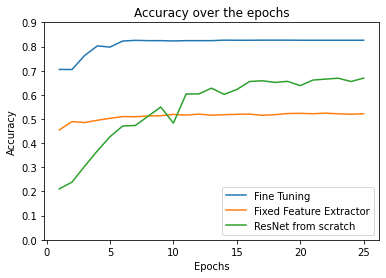

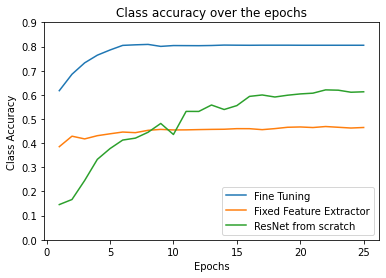

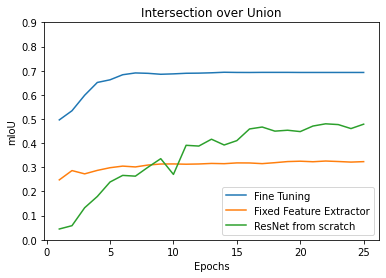

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
y_ticks = np.arange(0, 1, 0.1)
#x_ticks = [1,5,10,15,20,25]

epochs = [i for i in range(1,26)]

plt.figure(0)
plt.plot(epochs, fine_tuning_plt.acc, label='Fine Tuning')
plt.plot(epochs, fixed_feat_plt.acc, label='Fixed Feature Extractor')
plt.plot(epochs, resnet_plt.acc, label='ResNet from scratch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(y_ticks)
#plt.xticks(x_ticks)
plt.title('Accuracy over the epochs')
plt.legend()
plt.savefig('/content/drive/My Drive/accuracy.png')
plt.savefig('/content/drive/My Drive/accuracy-borderless.png',bbox_inches='tight')
plt.show()

plt.figure(1)
plt.plot(epochs, fine_tuning_plt.mAcc, label='Fine Tuning')
plt.plot(epochs, fixed_feat_plt.mAcc, label='Fixed Feature Extractor')
plt.plot(epochs, resnet_plt.mAcc, label='ResNet from scratch')
plt.xlabel('Epochs')
plt.ylabel('Class Accuracy')
plt.yticks(y_ticks)
plt.title('Class accuracy over the epochs')
plt.legend()
plt.savefig('/content/drive/My Drive/class_accuracy.png')
plt.savefig('/content/drive/My Drive/class_accuracy-borderless.png',bbox_inches='tight')
plt.show()


plt.figure(2)
plt.plot(epochs, fine_tuning_plt.mIoU, label='Fine Tuning')
plt.plot(epochs, fixed_feat_plt.mIoU, label='Fixed Feature Extractor')
plt.plot(epochs, resnet_plt.mIoU, label='ResNet from scratch')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.yticks(y_ticks)
plt.title('Intersection over Union')
plt.legend()
plt.savefig('/content/drive/My Drive/IoU.png')
plt.savefig('/content/drive/My Drive/IoU-borderless.png',bbox_inches='tight')
plt.show()


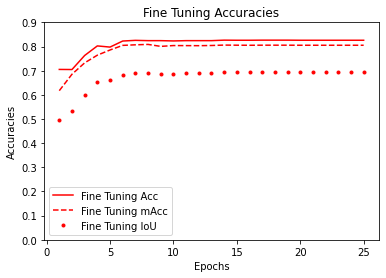

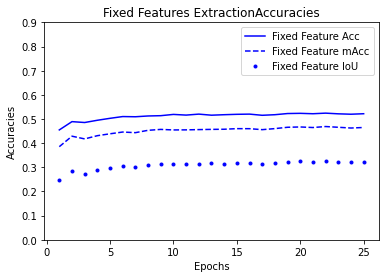

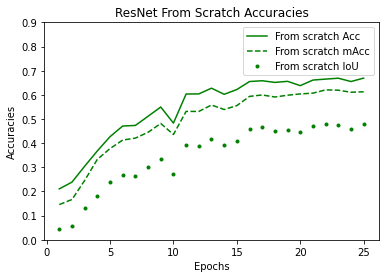

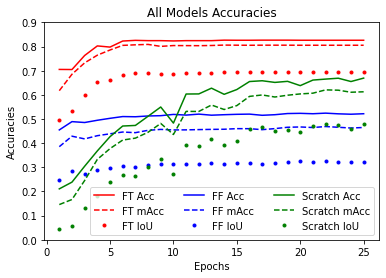

In [ ]:
plt.figure(3)
plt.plot(epochs, fine_tuning_plt.acc, 'r-', label='Fine Tuning Acc')
plt.plot(epochs, fine_tuning_plt.mAcc, 'r--', label='Fine Tuning mAcc')
plt.plot(epochs, fine_tuning_plt.mIoU, 'r.', label='Fine Tuning IoU')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.yticks(y_ticks)
plt.title('Fine Tuning Accuracies')
plt.legend()
plt.savefig('/content/drive/My Drive/fine-tuning-accuracies.png')
plt.savefig('/content/drive/My Drive/fine-tuning-accuracies-borderless.png',bbox_inches='tight')
plt.show()

plt.figure(4)
plt.plot(epochs, fixed_feat_plt.acc, 'b-', label='Fixed Feature Acc')
plt.plot(epochs, fixed_feat_plt.mAcc, 'b--', label='Fixed Feature mAcc')
plt.plot(epochs, fixed_feat_plt.mIoU, 'b.', label='Fixed Feature IoU')
plt.yticks(y_ticks)
plt.xlabel('Epochs')
plt.ylabel('Accuracies')

plt.title('Fixed Features ExtractionAccuracies')
plt.legend()
plt.savefig('/content/drive/My Drive/fixed-feat-accuracies.png')
plt.savefig('/content/drive/My Drive/fixed-feat-accuracies-borderless.png',bbox_inches='tight')
plt.show()

plt.figure(5)
plt.plot(epochs, resnet_plt.acc, 'g-', label='From scratch Acc')
plt.plot(epochs, resnet_plt.mAcc, 'g--', label='From scratch mAcc')
plt.plot(epochs, resnet_plt.mIoU, 'g.', label='From scratch IoU')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.yticks(y_ticks)
plt.title('ResNet From Scratch Accuracies')
plt.legend()
plt.savefig('/content/drive/My Drive/resnet-accuracies.png')
plt.savefig('/content/drive/My Drive/resnet-accuracies-borderless.png',bbox_inches='tight')
plt.show()


plt.figure(6)
plt.plot(epochs, fine_tuning_plt.acc, 'r-', label='FT Acc')
plt.plot(epochs, fine_tuning_plt.mAcc, 'r--', label='FT mAcc')
plt.plot(epochs, fine_tuning_plt.mIoU, 'r.', label='FT IoU')

plt.plot(epochs, fixed_feat_plt.acc, 'b-', label='FF Acc')
plt.plot(epochs, fixed_feat_plt.mAcc, 'b--', label='FF mAcc')
plt.plot(epochs, fixed_feat_plt.mIoU, 'b.', label='FF IoU')

plt.plot(epochs, resnet_plt.acc, 'g-', label='Scratch Acc')
plt.plot(epochs, resnet_plt.mAcc, 'g--', label='Scratch mAcc')
plt.plot(epochs, resnet_plt.mIoU, 'g.', label='Scratch IoU')

plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('All Models Accuracies')
plt.yticks(y_ticks)
#plt.legend(ncol=3,handleheight=1)
plt.legend(ncol=3)
plt.savefig('/content/drive/My Drive/accuracies.png')
plt.savefig('/content/drive/My Drive/accuracies-borderless.png',bbox_inches='tight')
plt.show()

In [ ]:
def sort_results(results):
  return sorted(results, key=lambda x: x.img_id)
  
sorted_results = sort_results(predictions)
print("Accuracy: {:.4f}".format(galaxy_recognizer[1]))

In [ ]:
import csv

with open('/content/results.csv', 'w') as f:
    writer = csv.writer(f)
    for res in sorted_results:
      writer.writerow([res.img_id, res.class_name])

In [ ]:
%tensorboard --logdir exps/Resnet50

In [ ]:
#Saving model
save_name = 'resnet50-pretrained1.pt'
path = F"/content/drive/My Drive/{save_name}" 
torch.save(model.state_dict(), path)